# LEE Analyzer Data/MC comparison plots


## Imports & Constants

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
import matplotlib.patches as patches

from helpfunction import sciNot,sciNot2,effErr

%matplotlib inline

pd.options.display.max_columns = 999
gr      = 1.618

mass_p= 0.93827 #GeV
mass_e= 0.00511 #GeV
z_dead_start = 675
z_dead_end=z_dead_start+100

In [2]:
catdefs={   1: 'Cosmic',
            2: 'e CC',
            3: 'mu CC',
            4: 'NC',
            5: 'Dirt',
            6: 'Data',
            7: 'Mixed',
            0: 'Other'}

pandora_pdg ={14:False,
              12:True}


def categoryPlus(row):
    label = catdefs[row['category']]
    if row['nu_pdg']==12:
        if label=='e CC':
            return r'$\nu_e$ CC     '
        elif label=='Mixed':
            return r'$\nu_e$ cont.   '
        else:
            return label+' '*(12-len( label))
    
    elif row['nu_pdg']==14:
        if label=='mu CC':
            return r'$\nu_{\mu}$ CC       '
        elif label=='Mixed':
            return r'$\nu_{\mu}$ cont.   '
        else:
            return  label+' '*(12-len( label))
        
    elif row['nu_pdg']==4294967282 or row['nu_pdg']==4294967284:
        return r'$\bar{\nu}_{\mu} / \bar{\nu}_e$          '
    elif row['nu_pdg']==15:
        return 'simulated LEE   '
    else:
        #print (row['nu_pdg'])
        return 'Cosmic intime '
    
# Formatting
def sciNotSpace(x):
    x=float(x)
    return "{:4.1f}".format(x)


#The statistical uncertainity per bin of the binned data.
#If there are weights then the uncertainity will be the root of the
#sum of the weights squared.
def hist_bin_uncertainty(data, weights, bin_edges):
    # Bound the data and weights to be within the bin edges
    in_range_index = [idx for idx in range(len(data)) if data[idx] > min(bin_edges) and data[idx] < max(bin_edges)]
    in_range_data = np.asarray([data[idx] for idx in in_range_index])
    in_range_weights = np.asarray([weights[idx] for idx in in_range_index])

    # Bin the weights with the same binning as the data
    bin_index = np.digitize(in_range_data, bin_edges)
    # N.B.: range(1, bin_edges.size) is used instead of set(bin_index) as if
    # there is a gap in the data such that a bin is skipped no index would appear
    # for it in the set
    binned_weights = np.asarray(
        [in_range_weights[np.where(bin_index == idx)[0]] for idx in range(1, len(bin_edges))])
    bin_uncertainties = np.asarray(
        [np.sqrt(np.sum(np.square(w))) for w in binned_weights])
    return bin_uncertainties

## Load Pickle file

In [3]:
# Used for plots: 
df_nu_test = pd.read_pickle('../Input/XGB_out/nu_test0123_xgb.pckl')
df_nue_test = pd.read_pickle('../Input/XGB_out/nue_test56789_xgb.pckl')
df_bnb     = pd.read_pickle('../Input/XGB_out/bnb_v11_xgb.pckl')
df_bnbext  = pd.read_pickle('../Input/XGB_out/bnbext_xgb.pckl')
df_lee     = pd.read_pickle('../Input/XGB_out/lee_xgb.pckl')
df_lee['nu_pdg']=15

#Used for training:
df_nu_train  = pd.read_pickle('../Input/XGB_out/nu_train4567_xgb.pckl')
df_nue_train = pd.read_pickle('../Input/XGB_out/nue_train01234_xgb.pckl')
df_intime_train = pd.read_pickle('../Input/XGB_out/intime_xgb.pckl')
df_lee_train = pd.read_pickle('../Input/XGB_out/lee_75k_xgb.pckl')
#df_intime_train["bnbweight"]=3

print('MC BNB nu test loaded from Pickle has '+str(len(df_nu_test.index))+' entries.' )
#print('MC BNB nue test loaded from Pickle has '+str(len(df_nue_test.index))+' entries.' )
#print('MC BNB nu train loaded from Pickle has '+str(len(df_nu_train.index))+' entries.' )
#print('MC BNB nue train loaded from Pickle has '+str(len(df_nue_train.index))+' entries.' )


# POT for the BNB nu test set file 0-3
pot_this = (
      3.268803486357006e+20+
      3.275377418388517e+20+
      3.2636240240463466e+20+
      3.2694485860610775e+20
     )
total_data_bnb_pot = 4.232e19#3.918e+19
total_data_pot     = 6.6e+20
lee_pot = 2.39861815e+21
scale_ext= 0.17#0.157

pot_ratio1 = pot_this/total_data_bnb_pot
pot_ratio2 = pot_this/total_data_pot

MC BNB nu test loaded from Pickle has 125782 entries.


In [4]:
dfs = [df_nu_test,df_lee,df_nu_train,df_nue_train,df_intime_train,df_lee_train]
for df in dfs:
    df['catplus']=df.apply(categoryPlus,axis=1)
    df['pandora_pdg'] = df['candidate_pdg'].map(pandora_pdg)
    df["reconstructed_energy"] = df.apply(lambda x: sum(x["track_energy_w"])+sum(x["shower_energy_w"]),axis=1) 
    df["dead_collection"] = ~df['vz'].between(z_dead_start,z_dead_end)
    
dfs_data = [df_bnb,df_bnbext]
for df in dfs_data:
    df['pandora_pdg'] = df['candidate_pdg'].map(pandora_pdg)
    df["reconstructed_energy"] = df.apply(lambda x: sum(x["track_energy_w"])+sum(x["shower_energy_w"]),axis=1) 
    df["dead_collection"] = ~df['vz'].between(z_dead_start,z_dead_end)
    
df_nu_test = df_nu_test[df_nu_test["dead_collection"]]
df_lee = df_lee[df_lee["dead_collection"]]
df_nu_train = df_nu_train[df_nu_train["dead_collection"]]
df_nue_train = df_nue_train[df_nue_train["dead_collection"]]
df_intime_train = df_intime_train[df_intime_train["dead_collection"]]
df_lee_train = df_lee_train[df_lee_train["dead_collection"]]

df_bnb = df_bnb[df_bnb["dead_collection"]]
df_bnbext = df_bnbext[df_bnbext["dead_collection"]]

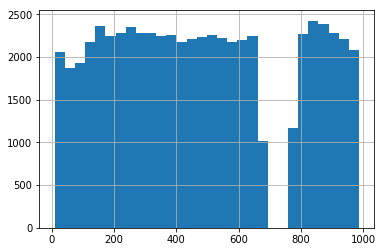

In [5]:
df_nu_train["vz"].hist(bins=30)

In [6]:
#df_nue_train["bnbweight"] = df_nue_train.apply(lambda x: x["bnbweight"]*20/(x["nu_E"]+0.2) if x["nu_E"]<0.6 else x["bnbweight"],axis=1)
df_nue_train[df_nue_train["reconstructed_energy"]<0.05].head(5)

,event,subrun,run,category,vx,vy,vz,bnbweight,candidate_pdg,numu_cuts,n_showers,n_tracks,flash_time_max,flash_PE_max,chargecenter_x,chargecenter_y,chargecenter_z,total_spacepoint_containment,vtx_activity_nr,shower_electron_score,track_muon_score,shower_muon_score,track_electron_score,track_closest_electron_score,shower_closest_electron_score,shower_cle_lee_score,track_energy_w,shower_energy_w,nu_daughters_pdg,nu_daughters_E,nu_pdg,nu_E,true_vx_sce,true_vy_sce,true_vz_sce,distance,ccnc,qsqr,theta,true_1eX_signal,true_nu_fiducial,lepton_E,lepton_theta,catplus,pandora_pdg,reconstructed_energy,dead_collection
1064,362158,7244,1,2,26.325222,-9.484838,293.608215,3.339364,12,13,2,0,4.349375,943.783563,27.735754,-6.533401,298.788666,1.0,2,[],[],[],[],[],[],[],[],"[0.04276021, 0.0]","[11, 2212]","[0.09873098089373539, 0.9437911085017953]",12,0.142642,26.848059,-14.144430,293.370970,4.694830,0,0.009595,0.850868,1,1,0.098731,0.852178,$\nu_e$ CC,True,0.042760,True
1454,298939,5979,1,2,126.245804,-18.861988,869.667603,0.540445,12,12,3,1,4.021250,614.051269,126.282272,-39.808060,871.378296,1.0,1,[0.21683694],[],[0.07709437],[],[],[0.017807558],[0.034398336],[0.0],"[0.0430384, 0.0, 0.0]","[11, 2112, 2212]","[0.16367248297729206, 0.9599031791944924, 0.96...",12,0.232309,126.695812,-45.377214,870.007601,26.521224,0,0.054755,1.287037,1,1,0.163672,1.285294,$\nu_e$ CC,True,0.043038,True
1614,436704,8735,2,1,113.770660,-23.323124,211.752411,0.537343,12,13,2,0,3.751250,513.875346,112.604507,-23.820831,215.316360,1.0,2,[],[],[],[],[],[],[],[],"[0.028454492, 0.0]","[11, 2212]","[0.15706325570317475, 1.147479415159545]",12,0.405077,196.822013,-3.431284,183.426333,89.975437,0,0.212638,2.306475,1,1,0.157063,2.307067,Cosmic,True,0.028454,True
1801,499686,9994,2,2,88.078918,57.153194,164.035294,0.534538,12,14,1,0,3.781250,1373.048030,45.465580,50.713734,195.562469,1.0,0,[0.3680675],[],[0.27853158],[],[],[0.011848156],[0.06362385],[],[0.048786998],"[11, 2212, 2112]","[0.24952499813167395, 0.938272013, 0.957719146...",12,0.317876,88.486178,57.276957,163.929158,0.438682,0,0.061463,0.911508,1,1,0.249525,0.911463,$\nu_e$ CC,True,0.048787,True
1951,386985,7740,1,2,65.054329,-7.651318,786.755005,0.543826,12,13,1,1,3.901250,549.805142,64.916603,-7.492421,788.253662,1.0,2,[],[],[],[],[],[],[],[0.024875956],[0.011241727],"[11, 2212, 2112]","[0.03462677150450441, 0.9757378653332286, 0.93...",12,0.154885,65.156966,-6.278300,790.381694,3.879251,0,0.016735,2.165532,1,1,0.034627,2.166918,$\nu_e$ CC,True,0.036118,True


## Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe1ad6eff60>]],
      dtype=object)

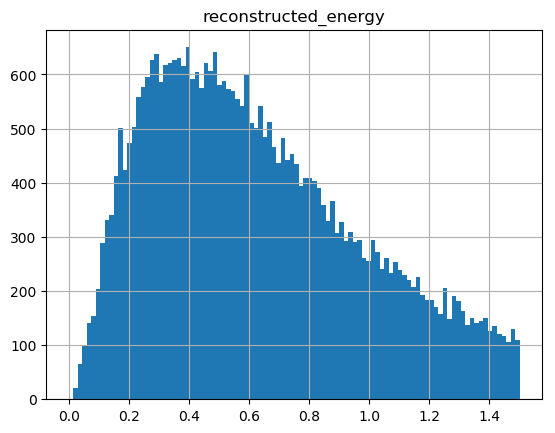

In [7]:
plt.style.use('default')
df_nue_train.hist('reconstructed_energy',bins=100,range=(0,1.5))

In [8]:
df_nu_test[df_nu_test['nu_pdg']==12].head()

,event,subrun,run,category,vx,vy,vz,bnbweight,candidate_pdg,numu_cuts,n_showers,n_tracks,flash_time_max,flash_PE_max,chargecenter_x,chargecenter_y,chargecenter_z,total_spacepoint_containment,vtx_activity_nr,shower_electron_score,track_muon_score,shower_muon_score,track_electron_score,track_closest_electron_score,shower_closest_electron_score,shower_cle_lee_score,track_energy_w,shower_energy_w,nu_daughters_pdg,nu_daughters_E,nu_pdg,nu_E,true_vx_sce,true_vy_sce,true_vz_sce,distance,ccnc,qsqr,theta,true_1eX_signal,true_nu_fiducial,lepton_E,lepton_theta,catplus,pandora_pdg,reconstructed_energy,dead_collection
12,418877,8378,4,7,94.257393,-68.151505,583.321960,0.839778,12,16,3,2,4.77125,3456.136362,109.395714,-64.020462,603.332336,0.970766,4,"[0.9238711, 0.03808771]","[0.0026679006, 0.0031647603]","[0.025803005, 0.09255399]","[0.0023077533, 0.005283065]","[0.0009414523, 0.002595834]","[0.8191045, 0.024343098]","[0.6436491, 0.040043958]","[0.21195793, 0.04832794]","[0.37978274, 0.016363626, 0.041523833]","[11, 2212, 2212, 2212]","[0.5206117897634492, 1.3228399329606266, 1.049...",12,1.209578,94.263973,-68.176404,583.516724,0.196459,0,0.373168,0.790200,1,1,0.520612,0.788653,$\nu_e$ cont.,True,0.697956,True
42,420451,8410,3,2,213.793579,-45.547771,818.628845,0.619122,12,13,4,0,3.99125,1670.075857,215.199402,-43.612469,846.158936,0.965934,1,"[0.6708913, 0.46980032]",[],"[0.010847686, 0.025916884]",[],[],"[0.3576954, 0.050882377]","[0.3701683, 0.12076854]",[],"[0.61513895, 0.07547596, 0.19624591, 0.013641309]","[11, 2112, 2212, 111]","[0.8484240132733077, 0.9450757170543228, 1.251...",12,1.678533,213.841504,-44.873501,818.336363,0.736534,0,0.180724,0.358146,1,1,0.848424,0.359867,$\nu_e$ CC,True,0.900502,True
43,420457,8410,3,2,25.802876,43.517204,151.183258,0.978333,12,14,1,1,3.69125,8583.896819,46.029312,-4.379336,186.913254,1.000000,1,[0.7305456],[0.33298495],[0.05504175],[0.70235914],[0.6052502],[0.085888624],[0.11382064],[0.25141054],[0.3521815],"[11, 2212, 2212, 2212, 2212, 2112, 2112, 2112,...","[0.6832722106126867, 0.9443101530506111, 0.950...",12,1.071205,26.145429,43.040388,151.412858,0.630407,0,0.628282,0.963315,1,1,0.683272,0.962486,$\nu_e$ CC,True,0.603592,True
99,390009,7801,4,2,82.802673,-33.857334,115.189102,0.541114,12,13,1,1,4.08875,3264.921709,56.589798,-31.105925,141.224945,1.000000,2,[0.84728545],[],[0.027561598],[],[],[0.85499245],[0.8919009],[0.025986984],[0.29577145],"[11, 2212, 2112]","[0.37529558707486804, 1.0079404459916121, 0.93...",12,0.489393,83.142974,-33.796552,115.033736,0.378996,0,0.116315,0.818451,1,1,0.375296,0.819673,$\nu_e$ CC,True,0.321758,True
118,182421,3649,3,5,71.367981,-95.370590,299.881256,0.610328,12,2,1,0,3.36125,872.497349,70.541397,-92.010574,301.073364,1.000000,1,[0.2412591],[],[0.29966122],[],[],[0.037964724],[0.17289582],[],[0.041567765],"[11, 2212, 111]","[0.6888782203089792, 1.5327309376923615, 0.250...",12,1.542023,71.934724,-166.213167,244.993881,89.619283,0,1.100782,1.068008,0,0,0.688878,1.067843,Dirt,True,0.041568,True


In [9]:
categories = ['$\\nu_e$ CC     ',
              '$\\nu_{\\mu}$ CC       ',
              '$\\nu_e$ cont.   ',
              '$\\nu_{\\mu}$ cont.   ',
              'NC          ',
              'Cosmic      ',
              'Dirt        ',
              '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$          ',
              
              ]


catlabs = ['$\\nu_e$ CC         ',
              '$\\nu_{\\mu}$ CC       ',
              '$\\nu_e$ cont.    ',
              '$\\nu_{\\mu}$ cont.   ',
              'NC           ',
              'Cosmic    ',
              'Dirt        ',
              '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$     ',]

In [10]:
# Plot of the selected events in true neutrino energy:
df=df_nu_test
entries= len(df.index)


print (categories)
true_E = []
reco_E = [] 
counter= []
labels = []
bnbweight=[]

for cat,catlab in zip(categories,catlabs):
    true_E.append(df[df['catplus']==cat]['nu_E'])
    reco_E.append(df[df['catplus']==cat]['reconstructed_energy'])
    bnbweight.append(df[df['catplus']==cat]['bnbweight'])  
    lab = catlab+ '('+str(     int(round(sum(bnbweight[-1])/pot_ratio2))) +')'
    labels.append(lab)
    


['$\\nu_e$ CC     ', '$\\nu_{\\mu}$ CC       ', '$\\nu_e$ cont.   ', '$\\nu_{\\mu}$ cont.   ', 'NC          ', 'Cosmic      ', 'Dirt        ', '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$          ']


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


114045
3    45065
1    25182
7    22025
4    15778
5     4603
2     1392
Name: category, dtype: int64


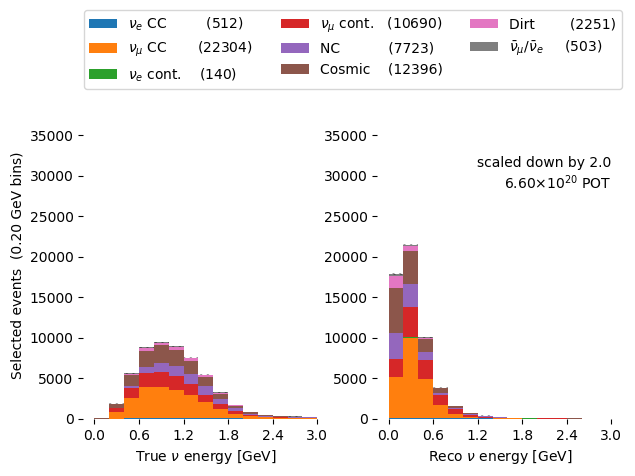

In [11]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4.3*gr,4),sharey=False,sharex=True)
N = 15
min_x = 0.0
max_x = 3.
max_y = 38000
step  = 0.6
binwidth=(max_x-min_x)/N

entries,edges,_ =ax[0].hist(true_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(true_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

entries,edges,_ = ax[1].hist(reco_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  


ax[0].set_ylabel('Selected events  ('+sciNot2(binwidth)+' GeV bins)')
ax[0].set_xlabel(r'True $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[0].set_ylim(0,max_y)
ax[1].set_ylim(0,max_y)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.35))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x,max_y*.75,'scaled down by '+sciNot(pot_ratio2)+"\n"+sciNot2(total_data_pot/1e20)+r'$\times 10^{20}$ POT',horizontalalignment='right')

plt.savefig("BNB_nu_before.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

print(len(df.index))
print(df['category'].value_counts())

In [12]:
# Plot of the selected events in true neutrino energy:

df = df_nu_test[df_nu_test.apply(lambda x: np.all(np.array(x['track_muon_score'])<0.13) and
                                   np.all(np.array(x['shower_muon_score'])<0.12) and
                                   (np.any(np.array(x['shower_closest_electron_score'])>0.80) or 
                                    np.any(np.array(x['track_closest_electron_score'])>0.6) ),
                                  axis=1)]

entries= len(df.index)

true_E = []
reco_E = [] 
counter= []
labels = []
bnbweight=[]

for cat,catlab in zip(categories,catlabs):
    true_E.append(df[df['catplus']==cat]['nu_E'])
    reco_E.append(df[df['catplus']==cat]['reconstructed_energy'])
    bnbweight.append(df[df['catplus']==cat]['bnbweight'])  
    print(cat)
    lab = catlab+ '('+str(     int(round(sum(bnbweight[-1])/pot_ratio2))) +')'
    labels.append(lab)
    
print(sum(bnbweight[0])/pot_ratio2)
print(sum(bnbweight[0])/sum(np.hstack(bnbweight)))

$\nu_e$ CC     
$\nu_{\mu}$ CC       
$\nu_e$ cont.   
$\nu_{\mu}$ cont.   
NC          
Cosmic      
Dirt        
$\bar{\nu}_{\mu} / \bar{\nu}_e$          
136.4883285294407
0.306943207440324


In [13]:
print(sum(bnbweight[0])/pot_ratio2)
print(sum(bnbweight[0])/sum(np.hstack(bnbweight)))

136.4883285294407
0.306943207440324


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


991
2    380
4    251
3    180
1     79
7     78
5     23
Name: category, dtype: int64


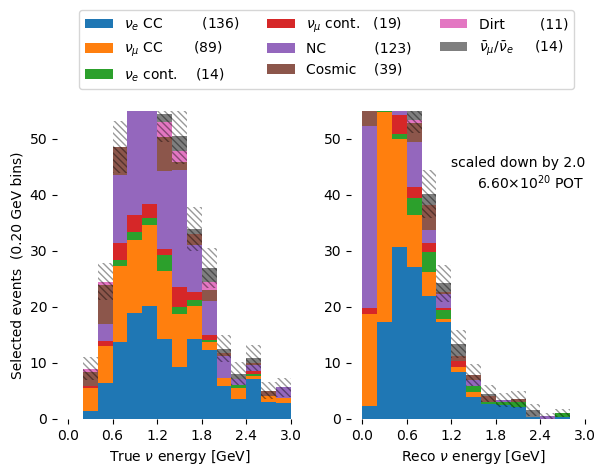

In [14]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4.3*gr,4),sharey=False,sharex=True)
N = 15
min_x = 0.0
max_x = 3.
max_y = 55
step  = 0.6
binwidth=(max_x-min_x)/N

entries,edges,_ =ax[0].hist(true_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(true_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

entries,edges,_ = ax[1].hist(reco_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  


ax[0].set_ylabel('Selected events  ('+sciNot2(binwidth)+' GeV bins)')
ax[0].set_xlabel(r'True $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[0].set_ylim(0,max_y)
ax[1].set_ylim(0,max_y)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.35))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x,max_y*.75,'scaled down by '+sciNot(pot_ratio2)+"\n"+sciNot2(total_data_pot/1e20)+r'$\times 10^{20}$ POT',horizontalalignment='right')

plt.savefig("BNB_nu_muanual.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

print(len(df.index))
print(df['category'].value_counts())

In [15]:
90/(90+21+31+4+4+2+15)

0.5389221556886228

In [16]:
df = df_nu_test[df_nu_test.apply(lambda x: np.all(np.array(x['track_muon_score'])<0.13) and
                                   np.all(np.array(x['shower_muon_score'])<0.12) and
                                   (np.any(np.array(x['shower_closest_electron_score'])>0.90) or 
                                    np.any(np.array(x['track_closest_electron_score'])>0.6) ),
                                  axis=1)]

In [17]:


print(len(df.index))
print(df['category'].value_counts())

562
2    258
4    132
3     77
7     48
1     33
5     14
Name: category, dtype: int64


In [18]:
1874/2.5*.75

562.2

# XGB $\nu_e$ score!

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from scipy.stats.mstats import gmean

In [20]:
def maxscore(arr):
    if len(arr)>0:
        return max(arr)
    else:
        return 0
    
def minscore(arr):
    if len(arr)>0:
        return min(arr)
    else:
        return 0
    
def avgscore(arr):
    if len(arr)>0:
        return gmean(arr)#sum(arr)/len(arr)
    else:
        return 0

In [21]:
def addScores(df_all):
    df_all['tr_mu_max']=df_all['track_muon_score'].apply(maxscore)
    df_all['tr_mu_avg']=df_all['track_muon_score'].apply(avgscore)
    df_all['sh_mu_max']=df_all['shower_muon_score'].apply(maxscore)
    df_all['sh_mu_avg']=df_all['shower_muon_score'].apply(avgscore)
    
    
    df_all['tr_e_max_temp']=df_all['track_electron_score'].apply(maxscore)
    mean = df_all['tr_e_max_temp'][df_all['tr_e_max_temp']>0].mean()
    df_all['tr_e_max']=df_all['tr_e_max_temp'].apply(lambda x: mean if x==0 else x)
    
    df_all['sh_e_max_temp']=df_all['shower_electron_score'].apply(maxscore)
    mean = df_all['sh_e_max_temp'][df_all['sh_e_max_temp']>0].mean()
    df_all['sh_e_max']=df_all['sh_e_max_temp'].apply(lambda x: mean if x==0 else x)

    df_all['sh_e_avg']=df_all['shower_electron_score'].apply(avgscore)
    
    df_all['tr_cle_max_temp']=df_all['track_closest_electron_score'].apply(maxscore)
    mean = df_all['tr_cle_max_temp'][df_all['tr_cle_max_temp']>0].mean()
    df_all['tr_cle_max']=df_all['tr_cle_max_temp'].apply(lambda x: mean if x==0 else x)

    df_all['sh_cle_max_temp']=df_all['shower_closest_electron_score'].apply(maxscore)
    mean = df_all['sh_cle_max_temp'][df_all['sh_cle_max_temp']>0].mean()
    df_all['sh_cle_max']=df_all['sh_cle_max_temp'].apply(lambda x: mean if x==0 else x)
    
    df_all['sh_cle_lee_max_temp']=df_all['shower_cle_lee_score'].apply(maxscore)
    mean = df_all['sh_cle_lee_max_temp'][df_all['sh_cle_lee_max_temp']>0].mean()
    df_all['sh_cle_lee_max']=df_all['sh_cle_lee_max_temp'].apply(lambda x: mean if x==0 else x)
    
    
    
    df_all['sh_energy']=df_all['shower_energy_w'].apply(lambda x: sum(x))
    
    df_all["n_objects"]=df_all["n_showers"]+df_all["n_tracks"]
    df_all["has_track"]=df_all["n_tracks"]>0
    return df_all

In [22]:
df_nue_train.head()

,event,subrun,run,category,vx,vy,vz,bnbweight,candidate_pdg,numu_cuts,n_showers,n_tracks,flash_time_max,flash_PE_max,chargecenter_x,chargecenter_y,chargecenter_z,total_spacepoint_containment,vtx_activity_nr,shower_electron_score,track_muon_score,shower_muon_score,track_electron_score,track_closest_electron_score,shower_closest_electron_score,shower_cle_lee_score,track_energy_w,shower_energy_w,nu_daughters_pdg,nu_daughters_E,nu_pdg,nu_E,true_vx_sce,true_vy_sce,true_vz_sce,distance,ccnc,qsqr,theta,true_1eX_signal,true_nu_fiducial,lepton_E,lepton_theta,catplus,pandora_pdg,reconstructed_energy,dead_collection
1,499608,9993,2,2,32.455017,43.230976,506.201843,0.536700,14,15,1,1,4.29125,8122.920194,22.865959,21.200096,534.734924,0.858158,1,[],[],[],[],[],[],[],[0.2844951],[0.15897378],"[11, 2212]","[0.2940342396420158, 1.2464336108359708]",12,0.640277,22.262252,10.333312,530.008609,41.867778,0,0.590215,2.174293,1,1,0.294034,2.172818,$\nu_e$ CC,False,0.443469,True
2,499611,9993,2,2,151.141342,81.714973,623.118591,0.839778,12,15,1,0,3.21125,1315.280490,167.855911,92.078430,671.168396,0.794613,1,[0.8025957],[],[0.03102097],[],[],[0.81838554],[0.797726],[],[0.66504985],"[11, 2212, 2212]","[1.1832599522612857, 0.9400738572713859, 0.938...",12,1.248453,151.446937,81.738230,623.125764,0.306562,0,0.248517,0.413090,1,1,1.183260,0.414820,$\nu_e$ CC,True,0.665050,True
3,499624,9993,2,2,75.291153,-33.451900,300.779968,1.013155,12,16,3,3,4.26125,11739.739198,68.250786,-31.659340,341.538788,1.000000,2,[0.6272254],"[0.05392716, 0.11843913]",[0.019624535],"[0.062948495, 0.09810529]","[0.022495896, 0.012013971]",[0.09730169],[0.09435633],"[0.044487443, 0.08898582, 0.057947095]","[0.3086602, 0.15318851, 0.049360406]","[11, -211, 211, 111, 2212]","[1.2824946162394415, 0.49194602260297826, 0.30...",12,2.504156,75.458628,-33.868408,300.297784,0.658808,0,0.489019,0.392734,1,1,1.282495,0.391676,$\nu_e$ CC,True,0.702629,True
4,499627,9993,2,2,124.862030,-27.151859,20.958126,0.906430,12,15,2,1,3.57125,4936.532499,123.114830,-24.752743,55.361275,1.000000,2,[0.9019764],[0.34994018],[0.013341646],[0.007916334],[0.0029677786],[0.89192146],[0.87480366],[0.17746639],"[0.72469264, 0.081874415]","[11, 2212]","[1.137157293731248, 1.8339507925641712]",12,2.072015,125.219937,-27.494201,21.363943,0.640299,0,1.167263,0.719250,1,1,1.137157,0.719156,$\nu_e$ CC,True,0.984033,True
5,499634,9993,2,2,149.228088,-41.191956,907.409546,0.617930,14,16,1,2,4.02125,1317.554068,148.577637,-48.035427,927.382080,1.000000,3,[],[0.3343642],[],[0.5205568],[0.15240799],[],[],"[0.20710598, 0.0098792305]",[0.0],"[11, 2112, 2112, 2112, 2112, 211, 2112]","[0.14910055924868562, 1.188302686826739, 0.997...",12,1.350428,147.137707,-60.259938,919.719341,22.792295,0,0.611341,2.115439,1,1,0.149101,2.113256,$\nu_e$ CC,False,0.216985,True


In [23]:
columns_train = ['tr_mu_max',"tr_mu_avg",'sh_mu_max','sh_mu_avg',
                 'sh_e_max','sh_e_avg','sh_cle_max',"sh_cle_lee_max",
                 'tr_cle_max',
                 'pandora_pdg',"vtx_activity_nr","total_spacepoint_containment","numu_cuts","has_track"]
#columns_train = ['tr_mu_max','sh_mu_max','sh_e_avg','tr_cle_max','sh_cle_max']

df_train = pd.concat([df_intime_train,df_nu_train,df_nue_train],ignore_index=True,copy=False)

df_train   = addScores(df_train)
df_nu_test = addScores(df_nu_test)

print(df_train.columns)
X_train = df_train[columns_train].as_matrix()
y_train = df_train['catplus']=='$\\nu_e$ CC     '
y_train_weights = df_train['bnbweight']

X_test = df_nu_test[columns_train].as_matrix()
y_test = df_nu_test['catplus']=='$\\nu_e$ CC     '
y_test_weights = df_nu_test['bnbweight']

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

Index(['event', 'subrun', 'run', 'category', 'vx', 'vy', 'vz', 'bnbweight',
       'candidate_pdg', 'numu_cuts', 'n_showers', 'n_tracks', 'flash_time_max',
       'flash_PE_max', 'chargecenter_x', 'chargecenter_y', 'chargecenter_z',
       'total_spacepoint_containment', 'vtx_activity_nr',
       'shower_electron_score', 'track_muon_score', 'shower_muon_score',
       'track_electron_score', 'track_closest_electron_score',
       'shower_closest_electron_score', 'shower_cle_lee_score',
       'track_energy_w', 'shower_energy_w', 'nu_daughters_pdg',
       'nu_daughters_E', 'nu_pdg', 'nu_E', 'true_vx_sce', 'true_vy_sce',
       'true_vz_sce', 'distance', 'ccnc', 'qsqr', 'theta', 'true_1eX_signal',
       'true_nu_fiducial', 'lepton_E', 'lepton_theta', 'catplus',
       'pandora_pdg', 'reconstructed_energy', 'dead_collection', 'tr_mu_max',
       'tr_mu_avg', 'sh_mu_max', 'sh_mu_avg', 'tr_e_max_temp', 'tr_e_max',
       'sh_e_max_temp', 'sh_e_max', 'sh_e_avg', 'tr_cle_max_temp',
       '

In [24]:
# fit model no training data
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

model = XGBClassifier()
model.fit(X_train, y_train,sample_weight=y_train_weights)
print(classification_report(y_test, model.predict(X_test)))
y_pred = model.predict_proba(X_test)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(len(columns_train)):
    print("%d. feature %s(%f)" % (f + 1, columns_train[indices[f]],importances[indices[f]]))

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

      False       1.00      0.95      0.97    112692
       True       0.14      0.62      0.23      1353

avg / total       0.99      0.95      0.97    114045

Feature ranking:
1. feature tr_mu_max(0.224138)
2. feature tr_cle_max(0.113506)
3. feature sh_e_max(0.096264)
4. feature sh_cle_lee_max(0.094828)
5. feature vtx_activity_nr(0.090517)
6. feature pandora_pdg(0.066092)
7. feature total_spacepoint_containment(0.061782)
8. feature sh_e_avg(0.057471)
9. feature sh_mu_avg(0.051724)
10. feature sh_mu_max(0.045977)
11. feature sh_cle_max(0.033046)
12. feature numu_cuts(0.030172)
13. feature has_track(0.017241)
14. feature tr_mu_avg(0.017241)


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Cut value: 0.79 keeps 37.1 % of nue CC events and 0.76 % of background events.


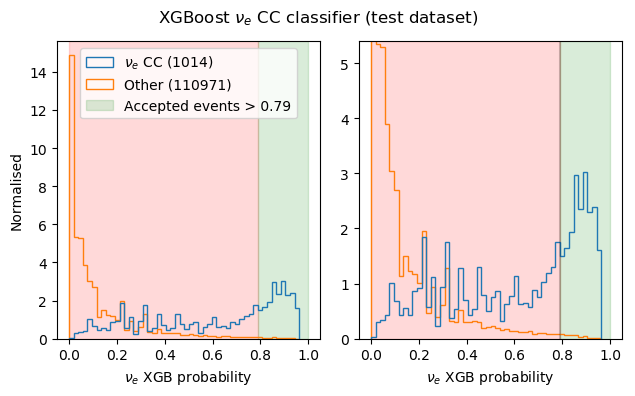

In [25]:
plt.style.use('default')
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4*gr,4),sharex=True)
plt.suptitle(r'XGBoost $\nu_e$ CC classifier (test dataset)')
N=50

nue_cut=0.79
# Electron track classification
arr_e  = y_pred[y_test==1][:,1]
arr_ne = y_pred[y_test==0][:,1]
arr_e_weigths  = y_test_weights[y_test==1]
arr_ne_weigths  = y_test_weights[y_test==0]


label_e=(r'$\nu_e$ CC ('+str(int(sum(arr_e_weigths)))+')','Other ('+str(int(sum(arr_ne_weigths)))+')')

ax[0].axvspan(nue_cut,0, alpha=0.15, color='red',label='_nolegend_')
ax[0].axvspan(nue_cut,1, alpha=0.15, color='green',label='Accepted events > '+str(nue_cut) )
ax[0].hist([arr_e,arr_ne],weights= [arr_e_weigths,arr_ne_weigths],  histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[0].set_ylabel('Normalised')
ax[0].set_xlabel(r'$\nu_e$ XGB probability')

ax[1].axvspan(nue_cut,0, alpha=0.15, color='red',label='_nolegend_')
ax[1].axvspan(nue_cut,1, alpha=0.15, color='green',label='Accepted events > '+str(nue_cut) )
ax[1].hist([arr_e,arr_ne],weights= [arr_e_weigths,arr_ne_weigths],histtype='step', bins=N, fill=False,label=label_e,density=True)
ax[1].set_ylim(0,5.4)
ax[1].set_xlabel(r'$\nu_e$ XGB probability')
ax[1].axvline(x=nue_cut,alpha=.2,color='k',label='Proposed cut: '+str(nue_cut))

#offset=0.05
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1],loc='upper center')

plt.tight_layout()
fig.subplots_adjust(top=0.9)
plt.savefig('XGB_nue.pdf')

print('Cut value:',nue_cut,'keeps', sciNot(sum(arr_e>nue_cut) / len(arr_e)*100),'% of nue CC events and',
      sciNot2(sum(arr_ne>nue_cut) / len(arr_ne)*100),'% of background events.')

In [26]:
df_nu_test['nue_predict'] = y_pred[:,1]

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [27]:
df_nu_test['nue_predict'].mean()
nue_cut=0.79

In [28]:
# Plot of the selected events in true neutrino energy:

df = df_nu_test[df_nu_test['nue_predict']>nue_cut]
entries= len(df.index)

true_E = []
reco_E = [] 
counter= []
labels = []
bnbweight=[]

for cat,catlab in zip(categories,catlabs):
    true_E.append(df[df['catplus']==cat]['nu_E'])
    reco_E.append(df[df['catplus']==cat]['reconstructed_energy'])
    bnbweight.append(df[df['catplus']==cat]['bnbweight'])  
    print(cat)
    lab = catlab+ '('+str(     int(round(sum(bnbweight[-1])/pot_ratio2))) +')'
    labels.append(lab)

$\nu_e$ CC     
$\nu_{\mu}$ CC       
$\nu_e$ cont.   
$\nu_{\mu}$ cont.   
NC          
Cosmic      
Dirt        
$\bar{\nu}_{\mu} / \bar{\nu}_e$          


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


1357
$\nu_e$ CC                                   502
NC                                           337
$\nu_{\mu}$ CC                               284
Cosmic                                        75
$\nu_{\mu}$ cont.                             52
$\nu_e$ cont.                                 52
$\bar{\nu}_{\mu} / \bar{\nu}_e$               28
Dirt                                          27
Name: catplus, dtype: int64


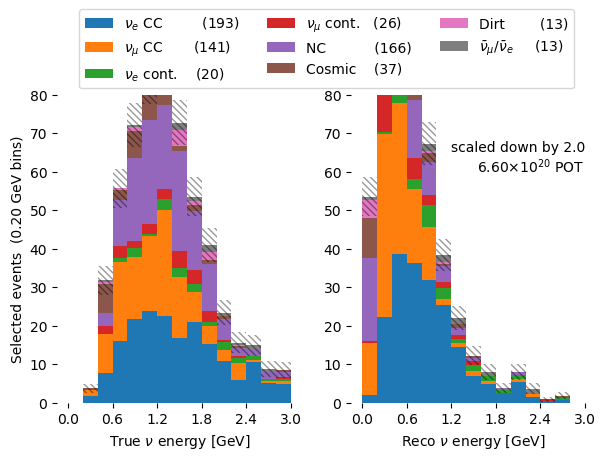

In [29]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4.3*gr,4),sharey=False,sharex=True)
N = 15
min_x = 0.0
max_x = 3.
max_y = 80
step  = 0.6
binwidth=(max_x-min_x)/N

entries,edges,_ =ax[0].hist(true_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(true_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

entries,edges,_ = ax[1].hist(reco_E,N,weights=np.array(bnbweight)/pot_ratio2, range=(min_x,max_x), stacked=True, fill=True,label=labels)
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E)), list(chain.from_iterable(bnbweight)),edges)
for err,entry,bin_start in zip(mc_err,entries[-1],edges[:-1]):
    sc_err = err/pot_ratio2
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  


ax[0].set_ylabel('Selected events  ('+sciNot2(binwidth)+' GeV bins)')
ax[0].set_xlabel(r'True $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[0].set_ylim(0,max_y)
ax[1].set_ylim(0,max_y)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.3))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x,max_y*.75,'scaled down by '+sciNot(pot_ratio2)+"\n"+sciNot2(total_data_pot/1e20)+r'$\times 10^{20}$ POT',horizontalalignment='right')

plt.savefig("BNB_nu_xgb.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

print(len(df.index))
print(df['catplus'].value_counts())

In [30]:
138/566

0.24381625441696114

In [31]:
118/(118+30+3+2+27+13+5+6)

0.5784313725490197

In [32]:
114/(114+31+4+2+33+16+5+7)

0.5377358490566038

# Data Monte Carlo

In [33]:
df_bnb   = addScores(df_bnb)
df_bnbext = addScores(df_bnbext)
df_lee = addScores(df_lee)
df_intime_train= addScores(df_intime_train)

df_bnb['nue_predict']    = model.predict_proba(df_bnb[columns_train].as_matrix())[:,1]
df_bnbext['nue_predict'] = model.predict_proba(df_bnbext[columns_train].as_matrix())[:,1]
df_lee['nue_predict'] = model.predict_proba(df_lee[columns_train].as_matrix())[:,1]
df_intime_train['nue_predict'] = model.predict_proba(df_intime_train[columns_train].as_matrix())[:,1]

/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

1.729062210256351


,event,subrun,run,category,vx,vy,vz,bnbweight,candidate_pdg,numu_cuts,n_showers,n_tracks,flash_time_max,flash_PE_max,chargecenter_x,chargecenter_y,chargecenter_z,total_spacepoint_containment,vtx_activity_nr,shower_electron_score,track_muon_score,shower_muon_score,track_electron_score,track_closest_electron_score,shower_closest_electron_score,shower_cle_lee_score,track_energy_w,shower_energy_w,pandora_pdg,reconstructed_energy,dead_collection,tr_mu_max,tr_mu_avg,sh_mu_max,sh_mu_avg,tr_e_max_temp,tr_e_max,sh_e_max_temp,sh_e_max,sh_e_avg,tr_cle_max_temp,tr_cle_max,sh_cle_max_temp,sh_cle_max,sh_cle_lee_max_temp,sh_cle_lee_max,sh_energy,n_objects,has_track,nue_predict
2749,1515,30,5328,6,53.474838,-61.123631,379.129730,1,12,14,3,0,4.369375,2554.336151,50.548901,-45.184593,406.116943,1.000000,3,"[0.8684136, 0.05190647]",[],"[0.018979061, 0.13858968]",[],[],"[0.7992109, 0.056493666]","[0.7939753, 0.08205161]",[],"[0.31800523, 0.07225092, 0.0025836476]",True,0.392840,True,0.000000,0.000000,0.138590,0.051286,0.000000,0.046439,0.868414,0.868414,0.212312,0.000000,0.020164,0.799211,0.799211,0.793975,0.793975,0.392840,3,False,0.792640
5860,582,11,5761,6,229.831711,-86.987625,523.043518,1,12,11,1,1,3.320000,1304.558567,201.038559,-84.965843,577.526550,1.000000,1,[],[0.066812165],[],[0.8873513],[0.7175695],[],[],[0.08257311],[0.38900483],True,0.471578,True,0.066812,0.066812,0.000000,0.000000,0.887351,0.887351,0.000000,0.329421,0.000000,0.717569,0.717569,0.000000,0.114088,0.000000,0.166214,0.389005,2,True,0.494827
6353,9135,182,5187,6,48.326393,-57.149658,350.665558,1,12,16,1,0,4.111250,1679.607128,48.010918,-54.549011,389.340851,1.000000,1,[0.9654706],[],[0.010432087],[],[],[0.9378204],[0.9501728],[],[0.36432946],True,0.364329,True,0.000000,0.000000,0.010432,0.010432,0.000000,0.046439,0.965471,0.965471,0.965471,0.000000,0.020164,0.937820,0.937820,0.950173,0.950173,0.364329,1,False,0.941385
7115,3463,69,5914,6,231.492493,14.538310,383.979248,1,12,17,1,1,4.621250,958.248428,239.458862,4.001616,419.426178,0.982321,1,[0.9497333],[],[0.01566526],[],[],[0.9090119],[0.9239068],[0.0],[0.3429927],True,0.342993,True,0.000000,0.000000,0.015665,0.015665,0.000000,0.046439,0.949733,0.949733,0.949733,0.000000,0.020164,0.909012,0.909012,0.923907,0.923907,0.342993,2,True,0.698394
8062,4517,90,5508,6,187.415131,59.502106,617.692749,1,12,13,2,0,3.511250,3162.865795,191.417297,53.507729,654.782104,1.000000,0,"[0.920446, 0.81369317]",[],"[0.009754041, 0.019180058]",[],[],"[0.77814114, 0.546194]","[0.74518496, 0.46056265]",[],"[1.3103946, 0.102087475]",True,1.412482,True,0.000000,0.000000,0.019180,0.013678,0.000000,0.046439,0.920446,0.920446,0.865425,0.000000,0.020164,0.778141,0.778141,0.745185,0.745185,1.412482,2,False,0.900772
10006,4196,83,5938,6,135.338348,-10.913978,815.124573,1,12,13,1,1,4.666875,3650.644979,125.234558,2.359660,854.349365,1.000000,2,[0.89063245],[],[0.01754586],[],[],[0.8450821],[0.74478817],[0.02590788],[0.78805226],True,0.813960,True,0.000000,0.000000,0.017546,0.017546,0.000000,0.046439,0.890632,0.890632,0.890632,0.000000,0.020164,0.845082,0.845082,0.744788,0.744788,0.788052,2,True,0.879916
11140,31,0,5513,6,178.879807,81.386681,27.969315,1,12,15,3,1,4.501250,1978.429023,158.757629,73.915993,89.883553,1.000000,3,[0.93054694],[],[0.026725322],[],[],[0.8964381],[0.851959],[0.01543776],"[0.7541027, 0.018333795, 0.014098972]",True,0.801973,True,0.000000,0.000000,0.026725,0.026725,0.000000,0.046439,0.930547,0.930547,0.930547,0.000000,0.020164,0.896438,0.896438,0.851959,0.851959,0.786535,4,True,0.895678


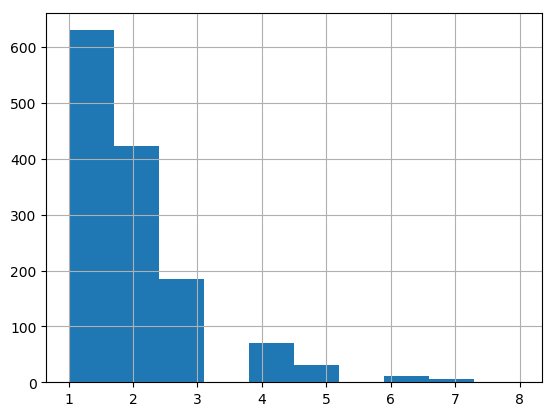

In [34]:
print(sum(df_lee['nue_predict']>nue_cut)*total_data_bnb_pot/lee_pot)
df_nu_test[df_nu_test["nue_predict"]>nue_cut]['n_showers'].hist()

df_bnb[ ((df_bnb["run"]==5328) & (df_bnb["subrun"]== 30) & (df_bnb["event"]==1515)) |
        ((df_bnb["run"]==5513) & (df_bnb["subrun"]==  0) & (df_bnb["event"]==  31)) |
        ((df_bnb["run"]==5187) & (df_bnb["subrun"]==182) & (df_bnb["event"]==9135)) |
        ((df_bnb["run"]==5508) & (df_bnb["subrun"]== 90) & (df_bnb["event"]==4517)) |
        ((df_bnb["run"]==5761) & (df_bnb["subrun"]== 11) & (df_bnb["event"]== 582)) |
        ((df_bnb["run"]==5914) & (df_bnb["subrun"]== 69) & (df_bnb["event"]==3463)) |
        ((df_bnb["run"]==5938) & (df_bnb["subrun"]== 83) & (df_bnb["event"]==4196))
      ].head(7)

In [35]:
# For MC
#['tr_mu_max','sh_mu_max','tr_e_max','sh_e_max','sh_e_avg','tr_cle_max','sh_cle_max']

df_before = df_nu_test
df_after  = df_nu_test[df_nu_test['nue_predict']>nue_cut]

nue_score_before = []
tr_mumax_score_before = []
reco_E_before = [] 
labels_before = []
bnbweight_before =[]

reco_E_after = [] 
labels_after = []
bnbweight_after =[]

catlabs = ['$\\nu_e$ CC        ',
              '$\\nu_{\\mu}$ CC        ',
              '$\\nu_e$ cont.     ',
              '$\\nu_{\\mu}$ cont.    ',
              'NC            ',
              'Cosmic    ',
              'Dirt         ',
              '$\\bar{\\nu}_{\\mu} / \\bar{\\nu}_e$       ']

for cat,catlab in zip(categories,catlabs):
    nue_score_before.append(df_before[df_before['catplus']==cat]['nue_predict'])
    tr_mumax_score_before.append(df_before[df_before['catplus']==cat]['tr_cle_max_temp'])
    
    reco_E_before.append(df_before[df_before['catplus']==cat]['reconstructed_energy'])
    reco_E_after.append(df_after[df_after['catplus']==cat]['reconstructed_energy'])
    
    bnbweight_before.append(df_before[df_before['catplus']==cat]['bnbweight']) 
    bnbweight_after.append(df_after[df_after['catplus']==cat]['bnbweight'])

    lab = catlab+ '('+str(     int(round(sum(bnbweight_after[-1])/pot_ratio1))) +')'
    labels_before.append(lab)
    lab = catlab+ '('+sciNot(sum(bnbweight_after[-1])/pot_ratio1) +')'
    labels_after.append(lab)
    
print([len(x)/pot_ratio1 for x in reco_E_before])
print([len(x)/pot_ratio1 for x in reco_E_after])

[43.785157131783166, 1448.7935695733927, 11.844321884872608, 694.7697993069125, 504.77522612088234, 807.1290495371795, 147.21262364558876, 32.36153520456997]
[16.24549067269412, 9.19067599809787, 1.6827998306376382, 1.6827998306376382, 10.905837363940078, 2.4271151403427473, 0.873761450523389, 0.906122985727959]


In [36]:
# for DATA

df_data = [df_bnb,df_bnbext,df_lee]

data_nue_score_before = []
data_tr_mumax_score_before = []

data_reco_E_before    = [] 
data_reco_E_after     = [] 


for index,df in enumerate(df_data):
    
    df_before = df
    df_after = df[df['nue_predict']>nue_cut]

    data_nue_score_before.append(df_before['nue_predict'])
    data_tr_mumax_score_before.append(df_before['tr_cle_max_temp'])
    
    data_reco_E_before.append(df_before['reconstructed_energy'])
    data_reco_E_after.append(df_after['reconstructed_energy'])
    
print([len(x) for x in data_reco_E_before])
print([len(x) for x in data_reco_E_after])

[10264, 29119, 1018]
[36, 75, 98]


In [37]:

df_bnb[df_bnb['nue_predict']>nue_cut][["run","subrun","event","vx","vy"]].to_csv("data_passed_final_20.csv",index=False)
df_bnb[df_bnb['nue_predict']>nue_cut].head(20)

,event,subrun,run,category,vx,vy,vz,bnbweight,candidate_pdg,numu_cuts,n_showers,n_tracks,flash_time_max,flash_PE_max,chargecenter_x,chargecenter_y,chargecenter_z,total_spacepoint_containment,vtx_activity_nr,shower_electron_score,track_muon_score,shower_muon_score,track_electron_score,track_closest_electron_score,shower_closest_electron_score,shower_cle_lee_score,track_energy_w,shower_energy_w,pandora_pdg,reconstructed_energy,dead_collection,tr_mu_max,tr_mu_avg,sh_mu_max,sh_mu_avg,tr_e_max_temp,tr_e_max,sh_e_max_temp,sh_e_max,sh_e_avg,tr_cle_max_temp,tr_cle_max,sh_cle_max_temp,sh_cle_max,sh_cle_lee_max_temp,sh_cle_lee_max,sh_energy,n_objects,has_track,nue_predict
365,496,9,5235,6,172.314743,48.961765,127.917717,1,12,14,1,0,4.351250,839.785116,175.321075,52.521755,130.646194,1.000000,1,[0.92397153],[],[0.050573625],[],[],[0.9149915],[0.94399863],[],[0.05198056],True,0.051981,True,0.000000,0.000000,0.050574,0.050574,0.000000,0.046439,0.923972,0.923972,0.923972,0.000000,0.020164,0.914991,0.914991,0.943999,0.943999,0.051981,1,False,0.892968
373,1581,31,5214,6,25.248085,-31.945488,316.627625,1,12,16,1,2,4.531250,5562.247207,26.021500,-33.393230,345.118896,0.932989,3,[0.915975],[0.38427788],[0.021007583],[0.043258157],[0.027335405],[0.8524996],[0.8543571],"[0.08949111, 0.07336273]",[0.44642764],True,0.609281,True,0.384278,0.384278,0.021008,0.021008,0.043258,0.043258,0.915975,0.915975,0.915975,0.027335,0.027335,0.852500,0.852500,0.854357,0.854357,0.446428,3,True,0.836405
819,2457,49,5215,6,182.932220,57.211002,577.130798,1,12,13,2,0,3.346875,706.310716,187.509903,29.341009,585.650696,1.000000,1,[0.87571335],[],[0.038706094],[],[],[0.75556886],[0.7092551],[],"[0.41420585, 0.0]",True,0.414206,True,0.000000,0.000000,0.038706,0.038706,0.000000,0.046439,0.875713,0.875713,0.875713,0.000000,0.020164,0.755569,0.755569,0.709255,0.709255,0.414206,2,False,0.820311
1223,723,14,5185,6,56.469803,95.990402,941.649536,1,12,11,1,0,4.231250,531.627859,50.759800,76.751152,946.811462,1.000000,1,[0.9171854],[],[0.046872657],[],[],[0.88979274],[0.9364135],[],[0.5185395],True,0.518539,True,0.000000,0.000000,0.046873,0.046873,0.000000,0.046439,0.917185,0.917185,0.917185,0.000000,0.020164,0.889793,0.889793,0.936414,0.936414,0.518539,1,False,0.884642
1299,6529,130,5332,6,242.976425,31.297325,460.447021,1,12,2,2,0,3.995000,583.993980,252.626328,40.228943,443.180481,0.125236,1,[0.87932515],[],[0.026971584],[],[],[0.90986633],[0.9044691],[],"[0.12678266, 0.0]",True,0.126783,True,0.000000,0.000000,0.026972,0.026972,0.000000,0.046439,0.879325,0.879325,0.879325,0.000000,0.020164,0.909866,0.909866,0.904469,0.904469,0.126783,2,False,0.813864
1324,4032,80,5153,6,202.954346,58.237106,810.395935,1,12,14,5,1,4.261250,1275.383492,206.010605,56.935059,852.541321,1.000000,4,"[0.17266214, 0.82503647]",[0.078790985],"[0.32345414, 0.013052393]",[0.010888053],[0.006025001],"[0.0009451885, 0.011641676]","[0.0016059421, 0.015829492]",[0.15426679],"[0.051280435, 0.06818642, 0.018425833, 0.22659...",True,0.518755,True,0.078791,0.078791,0.323454,0.064976,0.010888,0.010888,0.825036,0.825036,0.377429,0.006025,0.006025,0.011642,0.011642,0.015829,0.015829,0.364488,6,True,0.823657
2128,597,11,5511,6,41.468460,47.499287,984.117615,1,12,14,1,1,3.601250,2033.242042,38.424995,49.158047,999.356201,0.082930,2,[0.85331076],[0.5693172],[0.03343419],[0.012465181],[0.0051407814],[0.8544863],[0.888528],[0.037430506],[0.15636931],True,0.193800,True,0.569317,0.569317,0.033434,0.033434,0.012465,0.012465,0.853311,0.853311,0.853311,0.005141,0.005141,0.854486,0.854486,0.888528,0.888528,0.156369,2,True,0.848082
2261,9869,197,5705,6,69.442734,-33.067417,650.670593,1,12,13,1,0,4.231250,2711.164519,70.640892,-34.178314,656.351013,1.000000,1,[0.9560438],[],[0.028417233],[],[],[0.9382482],[0.95074147],[],[0.56731546],True,0.567315,True,0.000000,0.000000,0.028417,0.028417,0.000000,0.046439,0.956044,0.956044,0.956044,0.000000,0.020164,0.938248,0.938248,0.950741,0.950741,0.567315,1,False,0.962337
2749,1515,30,5328

[ 8 12  7  6  1  1  1  0]


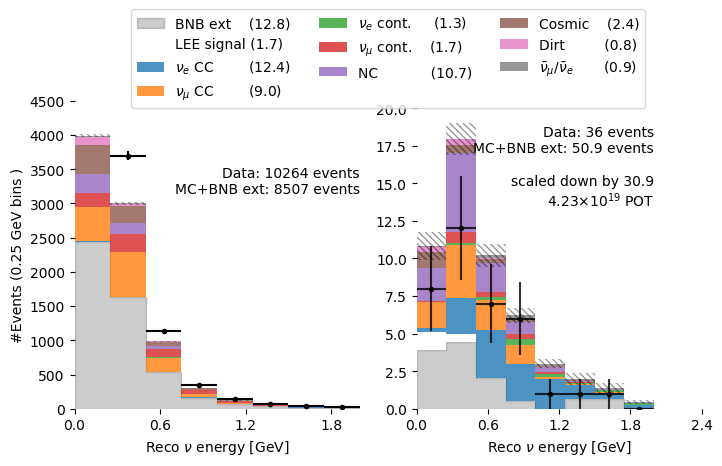

In [38]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5*gr,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 8
min_x = 0.0
max_x = 2.0
step  = 0.6
y_max1 = 4500
y_max2 = 20.5
binwidth=(max_x-min_x)/N
binhalf=binwidth/2

lower,edges,_ = ax[0].hist(np.array(data_reco_E_before[1]),weights=[scale_ext]*len(data_reco_E_before[1]) ,bins=N, range=(min_x,max_x), fill=True,histtype='step',alpha = 0.2, color= 'k')
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(labels_after,reco_E_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=0.8)
    lower+= lower_this
    
mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_reco_E_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+binhalf, bins, xerr=binhalf, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
ax[0].text(max_x,y_max1*.7, 'Data: '+str(len(data_reco_E_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events",horizontalalignment='right')
    
    
    
lower,edges,_= ax[1].hist(np.array(data_reco_E_after[1]),weights=[scale_ext]*len(data_reco_E_after[1]),bins=N, range=(min_x,max_x), fill=True,histtype='step',label='BNB ext    '+ '('+sciNot(len(data_reco_E_after[1])*scale_ext) +')',alpha = 0.2, color= 'k')
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext


lower_lee,_,_= ax[1].hist(np.array(data_reco_E_after[2]),weights=[total_data_bnb_pot/lee_pot]*len(data_reco_E_after[2]),bins=N, 
                          range=(min_x,max_x), fill=True,stacked=False,label='LEE signal '+ '('+sciNot(len(data_reco_E_after[2])*total_data_bnb_pot/lee_pot) +')',
                          alpha = 1.0, color= 'w',bottom=lower)
lower+=lower_lee
err_lee = np.sqrt(lower_lee/total_data_bnb_pot*lee_pot)*total_data_bnb_pot/lee_pot

for lab,arr,weights in zip(labels_after,reco_E_after,bnbweight_after):
    lower_this,_,_ = ax[1].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,label=lab,bottom=lower,alpha=0.8)
    lower+=lower_this

mc_err = hist_bin_uncertainty(list(chain.from_iterable(reco_E_after)), list(chain.from_iterable(bnbweight_after)),edges)
for err,entry,bin_start,err_cos,err_le in zip(mc_err,lower,edges[:-1],err_bnbext,err_lee):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2 + err_le**2 )
    ax[1].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    
bins,edges = np.histogram(data_reco_E_after[0],N, range=(min_x,max_x))
ax[1].errorbar(edges[:-1]+binhalf, bins, xerr=binhalf, yerr=np.sqrt(bins),alpha=0.8, color= 'k',fmt='.')

print(bins)

ax[0].set_ylabel('#Events ('+sciNot2(binwidth)+' GeV bins )')
ax[0].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[1].set_xlabel(r'Reco $\nu$ energy [GeV]')
ax[0].set_ylim(0,y_max1)
ax[1].set_ylim(0,y_max2)
ax[0].set_xlim(0,max_x)
ax[1].set_xlim(0,max_x)

plt.xticks(np.arange(min_x,max_x+step, step))
plt.legend(ncol=3,loc='upper center',bbox_to_anchor=(-0.1, 1.32))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)
ax[1].text(max_x,y_max2*.66, 'Data: '+str(len(data_reco_E_after[0]))+' events'+"\nMC+BNB ext: "+sciNot(sum(lower)-1.1)+" events\n\n"+'scaled down by '+sciNot(pot_ratio1)+"\n"+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')


plt.savefig("data_mc.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)


[1.23448905 1.22259508 1.27474563 1.01989381 1.10757728 1.12644381
 1.18649926 1.07842026 1.30943808 1.09731839 0.9564386  0.96972142
 1.05227961 1.03210115 0.91232134 0.9192445  0.64377923 0.58922186
 0.77696354 0.73483435]


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


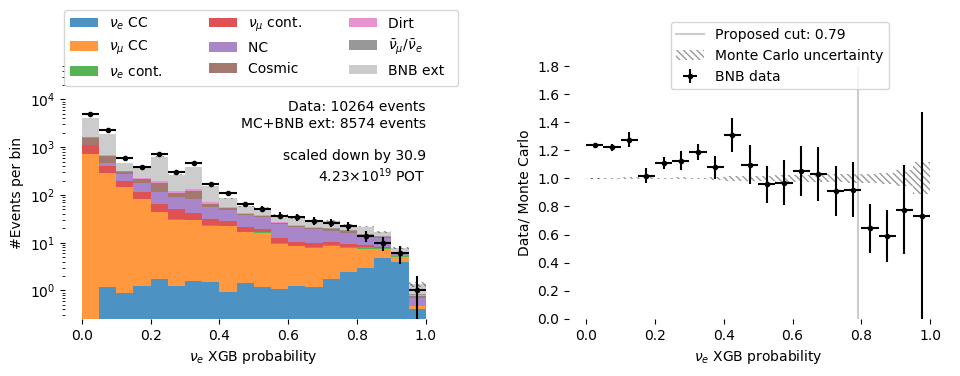

In [39]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 20
min_x = 0.0
max_x = 1.
step  = 0.2
y_max1 = 50000
y_max2 = 1.8
binwidth=(max_x-min_x)/N


    
lower=np.zeros(N)
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(catlabs,nue_score_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=0.8,label=lab)
    lower+= lower_this
lower_this,edges,_ = ax[0].hist(np.array(data_nue_score_before[1]),weights=[scale_ext]*len(data_nue_score_before[1]) ,bins=N, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,label='BNB ext ',alpha = 0.2, color= 'k')
lower+= lower_this
    
mc_err = hist_bin_uncertainty(list(chain.from_iterable(nue_score_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_nue_score_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+binwidth/2, bins, xerr=binwidth/2, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
ax[0].text(1,200, 'Data: '+str(len(data_nue_score_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events"+"\n\n"+'scaled down by '+sciNot(pot_ratio1)+"\n"+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')
     
print(bins/lower)   
ax[1].errorbar(edges[:-1]+binwidth/2, bins/lower, xerr=binwidth/2, yerr=np.sqrt(bins)/lower,alpha=1.0, color= 'k',fmt='.',label = 'BNB data')
#ax[1].axhline(y=1) 
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)/entry
    if err == mc_err[0]:
        ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4,label='Monte Carlo uncertainty'))
    ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    
ax[1].axvline(x=nue_cut,alpha=.2,color='k',label='Proposed cut: '+str(nue_cut))

ax[0].set_yscale("log", nonposy='clip')
ax[0].set_ylabel('#Events per bin')
ax[0].set_xlabel(r'$\nu_e$ XGB probability')
ax[0].set_ylim(0,y_max1)
ax[1].set_ylim(0,y_max2)

ax[1].set_ylabel('Data/ Monte Carlo')
ax[1].set_xlabel(r'$\nu_e$ XGB probability')

plt.xticks(np.arange(min_x,max_x+step, step))
ax[0].legend(ncol=3,loc='upper center',bbox_to_anchor=(0.52, 1.25))
ax[1].legend(loc='upper left',bbox_to_anchor=(0.25, 1.2))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

plt.tight_layout(w_pad=3.)
plt.savefig("data_mc_score.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)


/home/wouter/Binaries/miniconda3/envs/mlenv/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


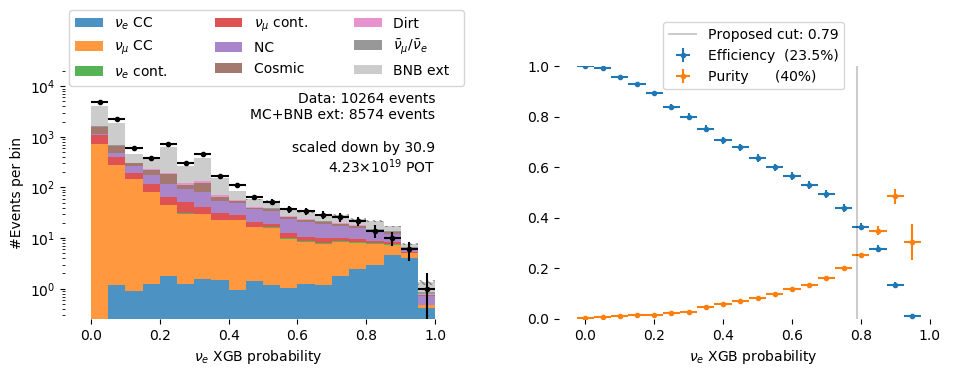

In [40]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 20
min_x = 0.0
max_x = 1.
step  = 0.2
y_max1 = 25000
y_max2 = 1.
binwidth=(max_x-min_x)/N


lower=np.zeros(N)
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(catlabs,nue_score_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=0.8,label=lab)
    lower+= lower_this
lower_this,edges,_ = ax[0].hist(np.array(data_nue_score_before[1]),weights=[scale_ext]*len(data_nue_score_before[1]) ,bins=N, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,label='BNB ext ',alpha = 0.2, color= 'k')
lower+= lower_this

mc_err = hist_bin_uncertainty(list(chain.from_iterable(nue_score_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_nue_score_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+binwidth/2, bins, xerr=binwidth/2, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
ax[0].text(1,200, 'Data: '+str(len(data_nue_score_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events"+"\n\n"+'scaled down by '+sciNot(pot_ratio1)+"\n"+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')
     

nu_e_CC,_ = np.histogram(nue_score_before[0],N,weights=bnbweight_before[0], range=(min_x,max_x))
mc_total  = lower*pot_ratio1
cum_nue = np.cumsum(nu_e_CC[::-1])[::-1] 
cum_tot = np.cumsum(mc_total[::-1])[::-1] 
cum_nue_eff=cum_nue/cum_nue[0]

ax[1].axvline(x=nue_cut,alpha=.2,color='k',label='Proposed cut: '+str(nue_cut))
ax[1].errorbar(edges[:-1], cum_nue_eff, xerr=binwidth/2, yerr=effErr(cum_nue,cum_nue[0]),alpha=1.0, fmt='.',label='Efficiency  (23.5%)')
ax[1].errorbar(edges[:-1], cum_nue/cum_tot, xerr=binwidth/2, yerr=effErr(cum_nue,cum_tot),alpha=1.0, fmt='.',label='Purity      (40%)')
ax[1].legend(loc='upper left',bbox_to_anchor=(0.3, 1.1))

ax[0].set_yscale("log", nonposy='clip')
ax[0].set_ylabel('#Events per bin')
ax[0].set_xlabel(r'$\nu_e$ XGB probability')
ax[0].set_ylim(0,y_max1)
ax[1].set_ylim(0,y_max2)

ax[1].set_xlabel(r'$\nu_e$ XGB probability')

plt.xticks(np.arange(min_x,max_x+step, step))
ax[0].legend(ncol=3,loc='upper center',bbox_to_anchor=(0.52, 1.25))
ax[1].legend(loc='upper left',bbox_to_anchor=(0.25, 1.2))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

plt.tight_layout(w_pad=3.)
plt.savefig("eff_pur_score.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)



[1.19929063 1.20303436 1.54235165 1.0459294  0.90942853 1.23355814
 0.75948797 1.07591615 0.40455017 0.37424524 0.38311654 1.80367698
 1.05244602 0.64395833 1.13968142 0.69263252 0.         0.
 0.         0.        ]


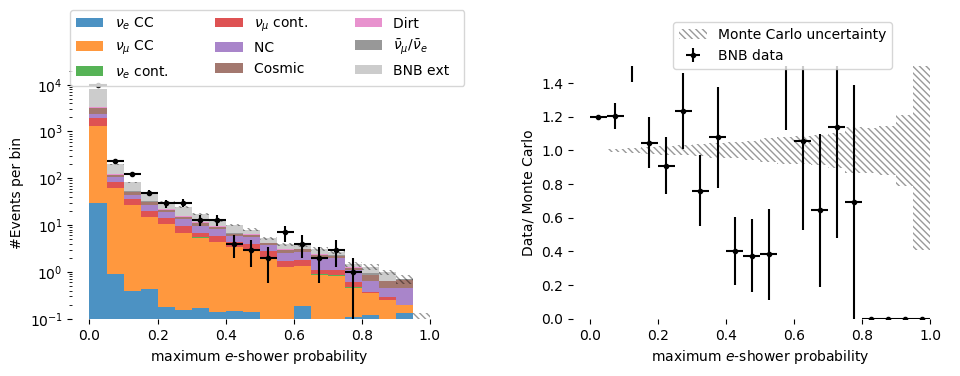

In [41]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 20
min_x = 0.0
max_x = 1.
step  = 0.2
y_max1 = 25000
y_max2 = 1.5
binwidth=(max_x-min_x)/N


    
lower=np.zeros(N)
err_bnbext = np.sqrt(lower/scale_ext)*scale_ext
for lab,arr,weights in zip(catlabs,tr_mumax_score_before,bnbweight_before):
    lower_this,_,_ = ax[0].hist(arr,N,weights=weights/pot_ratio1, range=(min_x,max_x), stacked=False, fill=True,bottom=lower,alpha=0.8,label=lab)
    lower+= lower_this
lower_this,edges,_ = ax[0].hist(np.array(data_tr_mumax_score_before[1]),weights=[scale_ext]*len(data_tr_mumax_score_before[1]) ,bins=N, range=(min_x,max_x),bottom=lower,stacked=False, fill=True,label='BNB ext ',alpha = 0.2, color= 'k')
lower+= lower_this

mc_err = hist_bin_uncertainty(list(chain.from_iterable(tr_mumax_score_before)), list(chain.from_iterable(bnbweight_before)),edges)
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)
    ax[0].add_patch(patches.Rectangle( (bin_start, entry-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
  
bins,edges = np.histogram(data_tr_mumax_score_before[0],N, range=(min_x,max_x))
ax[0].errorbar(edges[:-1]+binwidth/2, bins, xerr=binwidth/2, yerr=np.sqrt(bins),alpha=1.0, color= 'k',fmt='.')
#ax[0].text(0.7,2000, 'Data: '+str(len(data_tr_mumax_score_before[0]))+' events'+"\nMC+BNB ext: "+str(int(round(sum(lower))))+" events"+"\n\n"+'scaled down by '+sciNot(pot_ratio1)+"\n"+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT',horizontalalignment='right')
     
print(bins/lower)   
ax[1].errorbar(edges[:-1]+binwidth/2, bins/lower, xerr=binwidth/2, yerr=np.sqrt(bins)/lower,alpha=1.0, color= 'k',fmt='.',label = 'BNB data')
#ax[1].axhline(y=1) 
for err,entry,bin_start,err_cos in zip(mc_err,lower,edges[:-1],err_bnbext):
    sc_err = err/pot_ratio1
    sc_err = np.sqrt( sc_err**2 + err_cos**2)/entry
    if err == mc_err[0]:
        ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4,label='Monte Carlo uncertainty'))
    ax[1].add_patch(patches.Rectangle( (bin_start, 1-sc_err), binwidth, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
    
ax[0].set_yscale("log", nonposy='clip')
ax[0].set_ylabel('#Events per bin')
ax[0].set_xlabel(r'maximum $e$-shower probability')
ax[0].set_ylim(0.1,y_max1)
ax[1].set_ylim(0,y_max2)

ax[1].set_ylabel('Data/ Monte Carlo')
ax[1].set_xlabel(r'maximum $e$-shower probability')

plt.xticks(np.arange(min_x,max_x+step, step))
ax[0].legend(ncol=3,loc='upper center',bbox_to_anchor=(0.52, 1.25))
ax[1].legend(loc='upper left',bbox_to_anchor=(0.25, 1.2))

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

plt.tight_layout(w_pad=3.)
plt.savefig("data_mc_sh_emax.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

# BNB nue intrinsic plots:

In [42]:
# Used for plots: 
df_nue_test       = pd.read_pickle('../Input/XGB_out/nue_test56789_xgb.pckl')
df_nue_nonpassed  = pd.read_pickle('../Input/nue/nue_nonpassed.pckl')

print('Passed: ',len(df_nue_test.index),'+',len(df_nue_train.index),' entries.')
print('Not-passed: ',len(df_nue_nonpassed.index),' entries.')

#Reset event weight skewing
#df_nue_train["bnbweight"] = df_nue_train.apply(lambda x: x["bnbweight"]/20*(x["nu_E"]+0.2) if x["nu_E"]<0.6 else x["bnbweight"],axis=1)

Passed:  42938 + 39047  entries.
Not-passed:  38251  entries.


In [ ]:
df_nue_passed = pd.concat([df_nue_train,df_nue_test],ignore_index=True,copy=False)
#df_nue_passed = df_nue_test
print('Passed: ',len(df_nue_passed.index),' entries.')
print('Not-passed: ',len(df_nue_nonpassed.index),' entries.')

df_nue_selected = addScores(df_nue_passed)

df_nue_selected['nue_predict']    = model.predict_proba(df_nue_selected[columns_train].as_matrix())[:,1]

print('weighted total :',str(sum(df_nue_passed['bnbweight'])+sum(df_nue_nonpassed['bnbweight']) ))
print('has shower and optical cuts:',str(sum(df_nue_passed['bnbweight'])))
print('in fiducial volume:',str(sum(df_nue_selected['bnbweight'])))
print('final selection :',str(sum(df_nue_selected[(df_nue_selected['nue_predict']>nue_cut) ]['bnbweight'])))
print('final selection pure :',str(sum(df_nue_selected[(df_nue_selected['nue_predict']>nue_cut) & (df_nue_selected['category']==2) ]['bnbweight'])))

In [ ]:
df_nue_selected.columns

In [ ]:
total_denom = sum(df_nue_passed['bnbweight'])+sum(df_nue_nonpassed['bnbweight']) 
true_E_denom = np.append( df_nue_nonpassed['nu_E'].values ,  df_nue_passed['nu_E'].values)
weight_denom = np.append( df_nue_nonpassed['bnbweight'].values ,  df_nue_passed['bnbweight'].values)

total_nom_3 = sum(df_nue_selected[(df_nue_selected['nue_predict']>nue_cut)]['bnbweight'])
true_E_nom_3 = df_nue_selected[(df_nue_selected['nue_predict']>nue_cut) ]['nu_E'].values
weight_nom_3 = df_nue_selected[df_nue_selected['nue_predict']>nue_cut]['bnbweight'].values

total_nom_2 = sum(df_nue_selected[(df_nue_selected['nue_predict']>0)& (df_nue_selected['category']==2)]['bnbweight'])
true_E_nom_2 = df_nue_selected[(df_nue_selected['nue_predict']>0)   & (df_nue_selected['category']==2)]['nu_E'].values
weight_nom_2 = df_nue_selected[(df_nue_selected['nue_predict']>0)   & (df_nue_selected['category']==2)]['bnbweight'].values

total_nom_1 = sum(df_nue_selected[(df_nue_selected['nue_predict']>0)]['bnbweight'])
true_E_nom_1 = df_nue_selected[(df_nue_selected['nue_predict']>0)   ]['nu_E'].values
weight_nom_1 = df_nue_selected[(df_nue_selected['nue_predict']>0)   ]['bnbweight'].values

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(8,4),sharey=False,sharex=True)
#plt.suptitle(r'Passed events in True and Reconstructed $\nu$ Energy')
N = 35
min_x = 0.0
max_x = 3.5
binwidth=(max_x-min_x)/N
step=0.6

denom, edges = np.histogram(true_E_denom,bins=N,range=(min_x,max_x),weights=weight_denom)
nom1, _       = np.histogram(true_E_nom_1,bins=N,range=(min_x,max_x),weights=weight_nom_1)
nom2, _       = np.histogram(true_E_nom_2,bins=N,range=(min_x,max_x),weights=weight_nom_2)
nom3, _       = np.histogram(true_E_nom_3,bins=N,range=(min_x,max_x),weights=weight_nom_3)

eff1 = nom1/denom
eff2 = nom2/denom
eff3 = nom3/denom

ax[0].errorbar(edges[:-1]+0.05, eff1 , xerr=0.05, yerr=effErr(nom1,denom),alpha=1.0,fmt='.',label=r'$\nu_e$ $\varepsilon_{selected}$ ('+sciNot(sum(weight_nom_1)/sum(weight_denom)*100)+'%)')
ax[0].errorbar(edges[:-1]+0.05, eff2 , xerr=0.05, yerr=effErr(nom2,denom),alpha=1.0,fmt='.',label=r'$\nu_e$ $\varepsilon_{selected+category}$ ('+sciNot(sum(weight_nom_2)/sum(weight_denom)*100)+'%)')
ax[0].errorbar(edges[:-1]+0.05, eff3 , xerr=0.05, yerr=effErr(nom3,denom),alpha=1.0,fmt='.',label=r'$\nu_e$ $\varepsilon_{final}$ ('+sciNot(sum(weight_nom_3)/sum(weight_denom)*100)+'%)')

ax[1].hist(true_E_denom,weights= weight_denom, bins=edges[:-1],histtype='step',fill=False,stacked='False',density=True,color='k',lw=3,alpha=0.3,label=r'BNB $\nu_e$ spectrum')
ax[1].hist(true_E_nom_1,weights= weight_nom_1, bins=edges[:-1],histtype='step',fill=False,stacked='False',density=True)
ax[1].hist(true_E_nom_2,weights= weight_nom_2, bins=edges[:-1],histtype='step',fill=False,stacked='False',density=True)
ax[1].hist(true_E_nom_3,bins=edges[:-1],weights= weight_nom_3,histtype='step',fill=False,stacked='False',density=True,lw=3,alpha=0.5,label=r'Final $\nu_e$ selection')

ax[0].set_frame_on(False)
ax[1].set_frame_on(False)

ax[0].set_ylabel('Efficiency ('+sciNot2(binwidth)+' GeV bins)')
ax[1].set_ylabel('Area normalised ('+sciNot2(binwidth)+' GeV bins)')

ax[0].set_xlim(min_x,max_x)
ax[1].set_xlim(min_x,3.5)

ax[0].set_ylim(0,1.)

ax[0].set_xlabel(r'True $\nu_e$ energy [GeV]')
ax[1].set_xlabel(r'True $\nu_e$ energy [GeV]')

ax[0].legend(loc='upper center',bbox_to_anchor=(0.5, 1.2))
ax[1].legend(loc='upper left',bbox_to_anchor=(0.5, 1.2))

plt.tight_layout(w_pad=3.)
plt.savefig("eff.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

In [ ]:
g = sns.JointGrid(x="nu_E", y="nue_predict",data=df_nue_selected.head(5000),xlim=(0,3.5),ylim=(0.0,1.0))
g.plot_joint(sns.kdeplot,shade=True,cmap="Blues") 
g.plot_marginals(sns.distplot,bins=40)

In [ ]:
g = sns.JointGrid(x="bnbweight", y="nu_E",data=df_nue_selected.head(5000),xlim=(0.3,1.5),ylim=(0.0,5.0))
g.plot_joint(sns.kdeplot,shade=True,cmap="Blues") 
g.plot_marginals(sns.distplot,bins=40)

In [ ]:
pot_this = (
      1.89272433274e+20+
      1.91309713975e+20+
      1.90737421086e+20+
      1.89951666858e+20+
      1.9120295451e+20+
      1.90577422202e+20+
      1.91193765533e+20
     )
total_events_nu = 1888600
total_events_intime = 956046
total_pot_nu = 1.90601703789e+21
total_data_bnb_pot = 4.571e+19
intime_scaling = 10.279*(total_events_nu/total_events_intime)*(total_data_bnb_pot/total_pot_nu)

In [ ]:
#Cosmic intime scaling:
intime_scaling

In [ ]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(9.5,4),sharey=False,sharex=False)
nr_ext = str(int(len(df_bnbext.index)*scale_ext))
nr_intime = str(int(len(df_intime_train.index)*intime_scaling))

err_bnbext = np.sqrt(lower/scale_ext)*scale_ext

ax[2].hist(df_bnbext['nue_predict'],bins=50,weights=np.full(len(df_bnbext.index),scale_ext), range=(0,1),histtype='step',label='BNB ext (MCC8.8)',alpha=1.0)
ax[2].hist(df_intime_train['nue_predict'],bins=50,weights=np.full(len(df_intime_train.index),intime_scaling), range=(0,1),histtype='step',label='Cosmic intime (MCC8.7)',alpha=1.0)
ax[2].set_xlabel(r'$\nu_e$ XGB probability')
ax[2].set_yscale("log", nonposy='clip')
ax[2].set_title(r'$\nu_e$ CC inclusive classifier')

ax[0].hist(df_bnbext['flash_PE'],bins=50,weights=np.full(len(df_bnbext.index),scale_ext), range=(0,10000),histtype='step',label='BNB ext (MCC8.8)',alpha=1.0)
ax[0].hist(df_intime_train['flash_PE'],bins=50,weights=np.full(len(df_intime_train.index),intime_scaling), range=(0,10000),histtype='step',label='Cosmic intime (MCC8.7)',alpha=1.0)
ax[0].set_xlabel('Photon-electrons')
ax[0].set_yscale("log", nonposy='clip')
ax[0].set_title('Photo-electrons in Flash')

ax[1].hist(df_bnbext['reconstructed_energy'],bins=50,weights=np.full(len(df_bnbext.index),scale_ext), range=(0,2),histtype='step',label='BNB ext (MCC8.8)',alpha=1.0)
ax[1].hist(df_intime_train['reconstructed_energy'],bins=50,weights=np.full(len(df_intime_train.index),intime_scaling), range=(0,2),histtype='step',label='Cosmic intime (MCC8.7)',alpha=1.0)
ax[1].set_xlabel('E [GeV]')
ax[1].set_yscale("log", nonposy='clip')
ax[1].set_title('Reconstructed energy')

ax[0].set_ylabel('Events per bin')
ax[0].text(9999,200, "Scaled to "+sciNot2(total_data_bnb_pot/1e19)+r'$\times 10^{19}$ POT'+"\n\n"+
           'Data: '+nr_ext+' events'+"\nMC: "+nr_intime+' events'
           ,horizontalalignment='right')
plt.legend()

plt.tight_layout(w_pad=1.)
plt.savefig("intime.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)